# Group 005 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [2]:
# import zipfile
# with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
1698185,2770000,2019-04-29,06:02:15,55.084655,82.643899,9654,1,5,5,3,59.0,7.50,1
1992021,2300000,2019-06-14,06:19:16,54.946526,82.973030,9654,1,6,10,3,87.0,12.92,11
3850665,4100000,2020-06-05,14:39:50,47.248999,39.699220,3230,3,8,17,2,80.0,20.00,11
1014296,1700000,2019-01-27,11:15:48,56.353417,61.976603,6171,1,1,5,3,59.0,8.00,1
5219591,37900000,2021-03-25,20:51:34,59.962480,30.310253,2661,3,5,6,5,211.0,27.00,1


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [6]:
MOSCOW_CODE = 81
MAX_NUM_SAMPLES = 100000
SEED = 69

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]
moscow_df['price'] = moscow_df['price'] * 1e-4

# cap number of elements
moscow_df = moscow_df.sample(MAX_NUM_SAMPLES, random_state=SEED)

In [7]:
moscow_df.isnull().values.any()

False

In [8]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
1334571,750.000,2019,brick,6,9,3,67.1,6.7,preowned
3056085,748.619,2019,monolithic,5,9,3,77.9,22.0,new
2534493,890.000,2019,monolithic,10,18,2,60.3,22.0,new
263001,723.294,2018,panel,12,14,3,85.8,18.6,new
4690270,725.000,2020,panel,9,17,2,51.7,9.0,preowned


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [9]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,475.638567,2019.310120,7.053700,12.752370,1.776320,51.592710,10.362995
std,296.411050,0.880621,5.692804,7.411351,0.862656,21.748209,6.834285
min,0.150000,2018.000000,1.000000,1.000000,0.000000,2.400000,0.120000
25%,300.000000,2019.000000,3.000000,5.000000,1.000000,38.000000,7.000000
50%,430.000000,2019.000000,5.000000,12.000000,2.000000,46.000000,9.700000
75%,595.000000,2020.000000,10.000000,17.000000,2.000000,61.900000,12.000000
max,29774.130000,2021.000000,36.000000,38.000000,9.000000,997.000000,1131.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

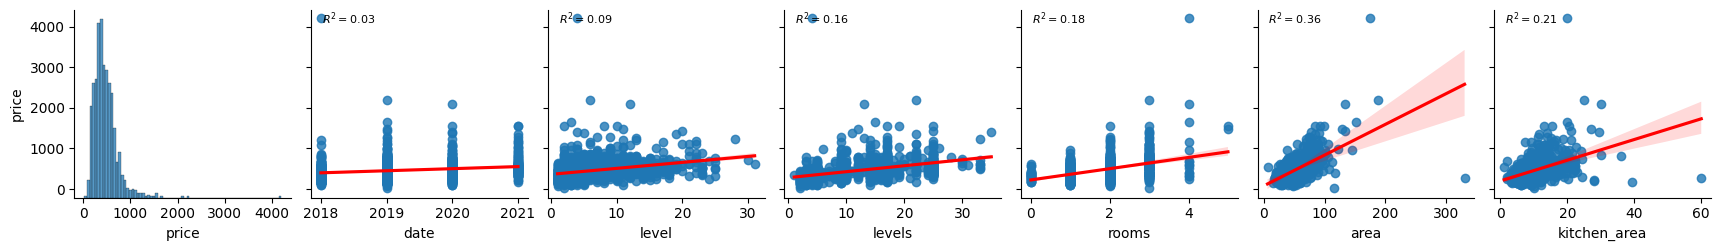

In [10]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like te might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

<Axes: >

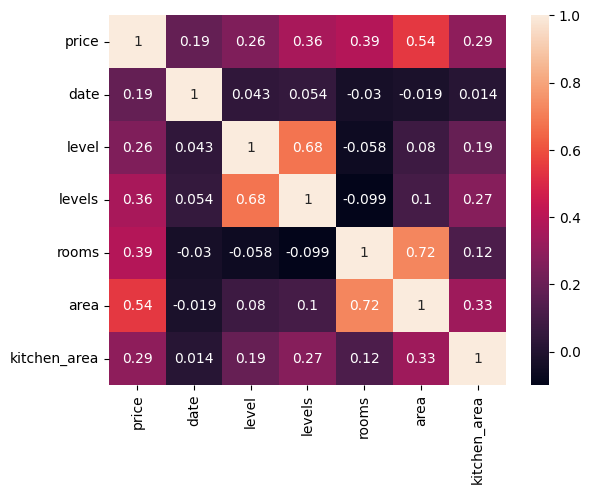

In [11]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [12]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

70000 train samples; 30000 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [13]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
1220467,2019,14,16,0,26.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1142562,2019,11,17,3,82.1,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4125605,2020,6,9,3,76.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2260584,2019,2,7,1,36.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3465715,2020,3,4,1,33.0,7.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [14]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
2578222,-0.350955,0.514697,0.567740,0.257887,-0.006395,-0.131316,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3778970,0.784297,2.976847,1.647581,-0.900040,-0.818456,0.040648,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1460289,-0.350955,-0.716377,-1.052022,0.257887,0.335766,-0.184227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
718297,-1.486208,-0.364642,0.432760,1.415813,1.558419,1.085657,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4613535,0.784297,-1.068113,-1.591942,1.415813,-0.029206,-0.316507,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [15]:
# MAX_EPOCHS = 1000000

### Linear Regression

Note that SckiKit doesn't offer MAE loss for its `LinearRegression` implementation. However, `linear_model.SGDRegressor` can be made to use an MAE loss by using `epsilon_insensitive` loss and setting its $\epsilon$ hyperparam to $0$.

Note that this does mean we will be using SGD for descent, so our model will take more steps to converge and loss won't strcitly decrease, but in our case using SGD will actually be helpful since our dataset is relatively large, so each epoch will be much faster.

In [16]:
# from sklearn.linear_model import SGDRegressor

# linreg_mae_model = SGDRegressor(loss='epsilon_insensitive', epsilon=0, max_iter=MAX_EPOCHS, verbose=1)

In [17]:
# linreg_mae_model.fit(X_train_scaled, y_train)

In [18]:
# import pickle

# filename = 'trained_model.sav'
# pickle.dump(linreg_mae_model, open(filename, 'wb'))

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Random Forests for Regression

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=SEED, criterion='absolute_error', verbose=2)

In [26]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


In [ ]:
# rf_train_preds = rf_model.predict(X_train)
# rf_test_preds = rf_model.predict(X_test)

# rf_train_mae = mean_absolute_error(y_train, rf_train_preds)
# rf_test_mae = mean_absolute_error(y_test, rf_test_preds)

# rf_train_mse = mean_squared_error(y_train, rf_train_preds)
# rf_test_mse = mean_squared_error(y_test, rf_test_preds)

# rf_train_rmse = np.sqrt(rf_train_mse)
# rf_test_rmse = np.sqrt(rf_test_mse)

# print(f'Random Forest MAE train error: {rf_train_mae}, test error: {rf_test_mae}')
# print(f'Random Forest MSE train error: {rf_train_mse}, test error: {rf_test_mse}')
# print(f'Random Forest RMSE train error: {rf_train_rmse}, test error: {rf_test_rmse}')